In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pyfftw.interfaces.scipy_fftpack import rfft, rfftfreq, irfft

import os
from multiprocessing import cpu_count

import numba

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 2000)

# Loading data

In [11]:
MOTION_SENSOR_COLUMNS = ['attitude.roll', 'attitude.pitch', 'attitude.yaw', 
                         'gravity.x', 'gravity.y', 'gravity.z', 
                         'rotationRate.x', 'rotationRate.y', 'rotationRate.z', 
                         'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']

In [12]:
def denoise_data(data_frame, sampling_rate = 30):
    for reading in MOTION_SENSOR_COLUMNS:
        xf = rfftfreq(len(data_frame), 1 / sampling_rate)
        
        yf = rfft(data_frame[reading].to_numpy())
        
        #maximum frequency magnitude
        max_magnitude = np.amax(yf)

        yf[yf < 0.5 * max_magnitude] = 0

        new_reading = irfft(yf)

        data_frame[reading] = new_reading
    return

In [13]:
def load_raw_data(dataset_path, denoise = False):
    """
    Load data from csv files, denoise data from each file and concatenate all data into one data frame
    """
    
    # Load data from sensor:
    dirs = os.listdir(dataset_path)
    dfs = []
    for d in dirs:
        activity_name, experiment_id = d.split("_")
        for subject in os.listdir(os.path.join(dataset_path, d)):
            filepath = os.path.join(os.path.join(dataset_path, d), subject)
            
            df = pd.read_csv(filepath, index_col=0)
            
            if denoise:
                denoise_data(df)
            
            df['subject'] = int(subject.split(".")[0].split("_")[1]) # keep only the subject's numerical i.d.
            df['activity'] = activity_name
            df['experiment_id'] = int(experiment_id)
            df['experiment_step'] =  np.arange(0, len(df)) # assign a numerical step number for every measurement in the experiment
            dfs.append(df)

    final_df = pd.concat(dfs)

    return final_df

In [14]:
dataset_path = r"./Kaggle mock data/A_DeviceMotion_data"

raw_df = load_raw_data(dataset_path)

denoised_df = load_raw_data(dataset_path, denoise=True)

# Inspect Data

In [15]:
def plot_experiment_in_time_domain(df1, df2, subject, experiment_id):
    df1 = df1.loc[(df1['subject'] == subject) & (df1['experiment_id'] == experiment_id)]
    df2 = df2.loc[(df2['subject'] == subject) & (df2['experiment_id'] == experiment_id)]

    ATTITUDE_COLUMNS = ['attitude.roll', 'attitude.pitch', 'attitude.yaw']
    GRAVITY_COLUMNS = ['gravity.x', 'gravity.y', 'gravity.z']
    ROTATION_RATE_COLUMNS = ['rotationRate.x', 'rotationRate.y', 'rotationRate.z']
    ACCELERATION_COLUMNS = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']

    title1 = str.format("Subject {} Experiment {}_{} (Raw)", subject, df1['activity'][0], experiment_id)
    title2 = str.format("Subject {} Experiment {}_{} (Denoised)", subject, df2['activity'][0], experiment_id)
    
    df1.plot.line(x='experiment_step', y = ATTITUDE_COLUMNS, title = title1, figsize=(15,5))
    df2.plot.line(x='experiment_step', y = ATTITUDE_COLUMNS, title = title2, figsize=(15,5))
    
    df1.plot.line(x='experiment_step', y = GRAVITY_COLUMNS, title = title1, figsize=(15,5))
    df2.plot.line(x='experiment_step', y = GRAVITY_COLUMNS, title = title2, figsize=(15,5))
    
    df1.plot.line(x='experiment_step', y = ROTATION_RATE_COLUMNS, title = title1, figsize=(15,5))
    df2.plot.line(x='experiment_step', y = ROTATION_RATE_COLUMNS, title = title2, figsize=(15,5))
    
    df1.plot.line(x='experiment_step', y = ACCELERATION_COLUMNS, title = title1, figsize=(15,5))
    df2.plot.line(x='experiment_step', y = ACCELERATION_COLUMNS, title = title2, figsize=(15,5))
    
    return

In [16]:
def plot_experiment_in_frequency_domain(raw, denoised, subject, experiment_id):
    raw = raw.loc[(raw['subject'] == subject) & (raw['experiment_id'] == experiment_id)]
    denoised = denoised.loc[(denoised['subject'] == subject) & (denoised['experiment_id'] == experiment_id)]

    fig = plt.figure(figsize = (15,60))

    for index, reading in enumerate(MOTION_SENSOR_COLUMNS):
        
        xf = rfftfreq(len(raw), 1/30)
        yf = rfft(raw[reading].to_numpy())

        ax1 = fig.add_subplot(24, 1, index * 2 + 1)
        ax1.plot(xf, np.abs(yf))
        ax1.set_title(reading + " (Raw)")

        xf = rfftfreq(len(denoised), 1/30)
        yf = rfft(denoised[reading].to_numpy())

        ax2 = fig.add_subplot(24, 1, index * 2 + 2)
        ax2.plot(xf, np.abs(yf))
        ax2.set_title(reading + " (Denoised)")
    
    fig.tight_layout()
    plt.show()
    return

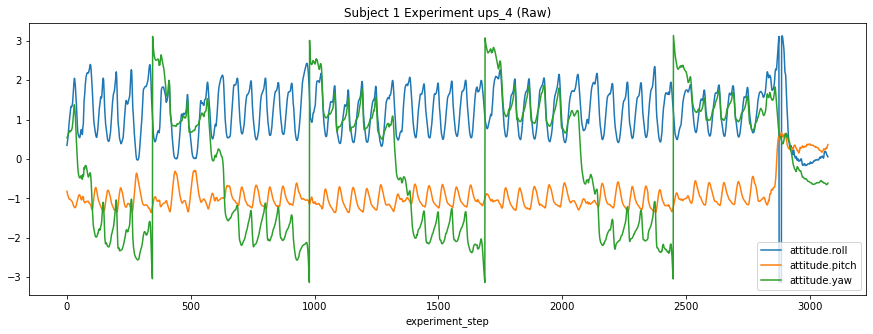

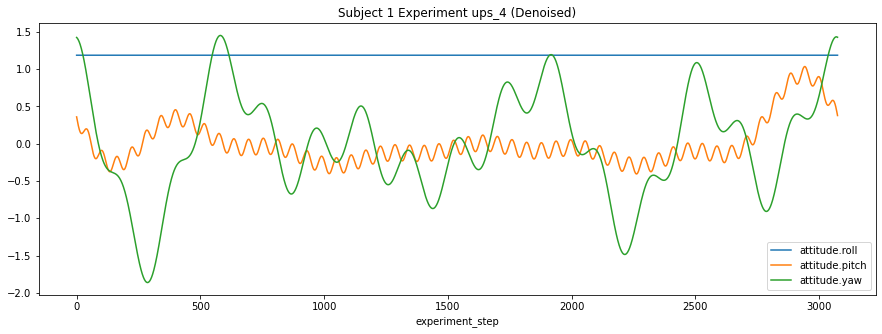

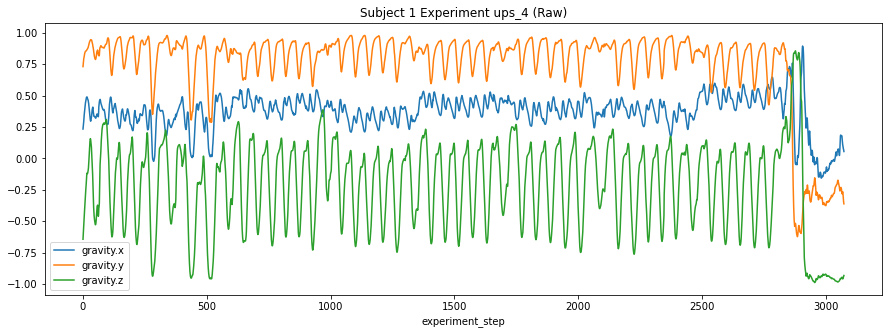

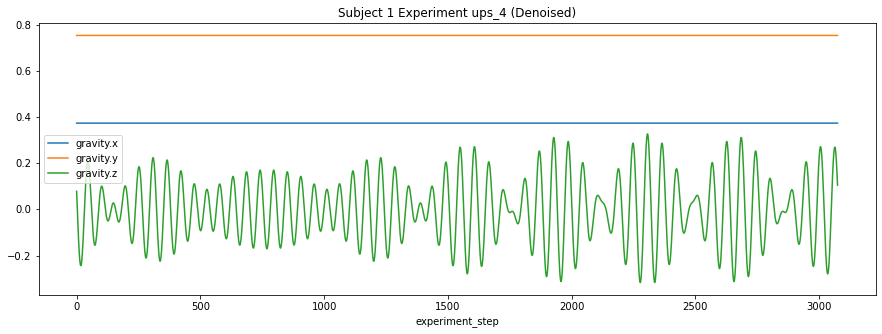

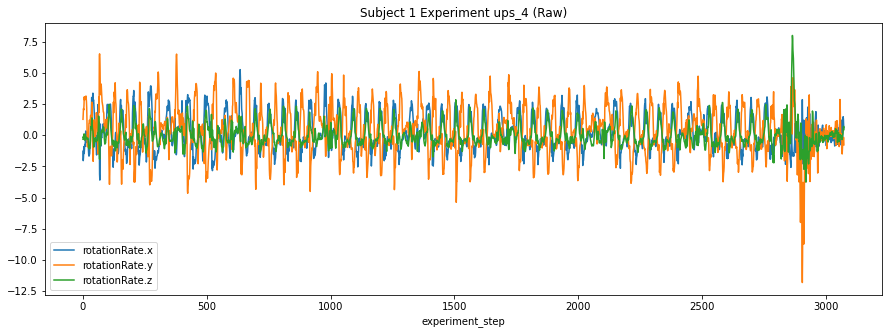

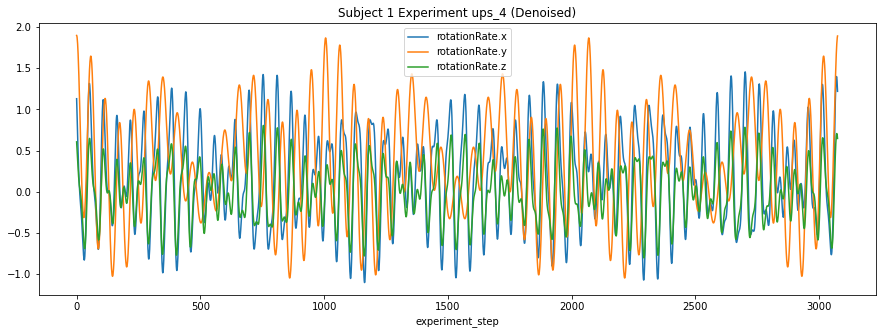

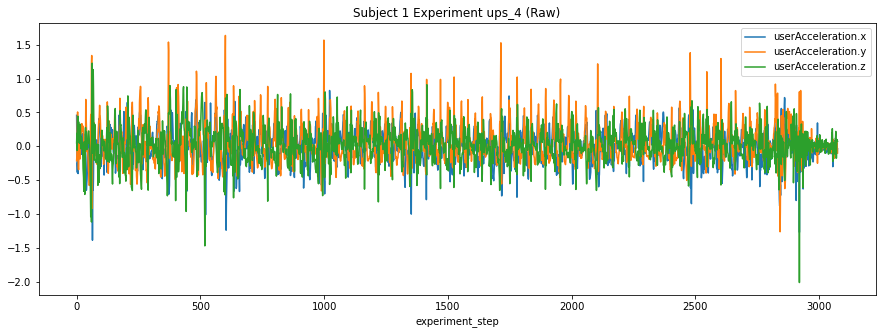

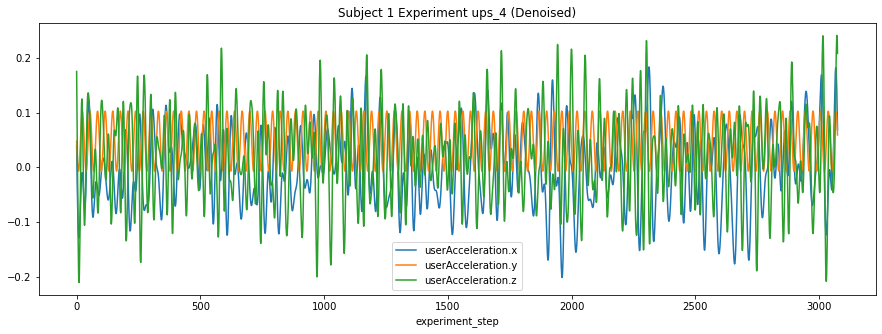

In [24]:
plot_experiment_in_time_domain(raw_df,denoised_df,1,4)

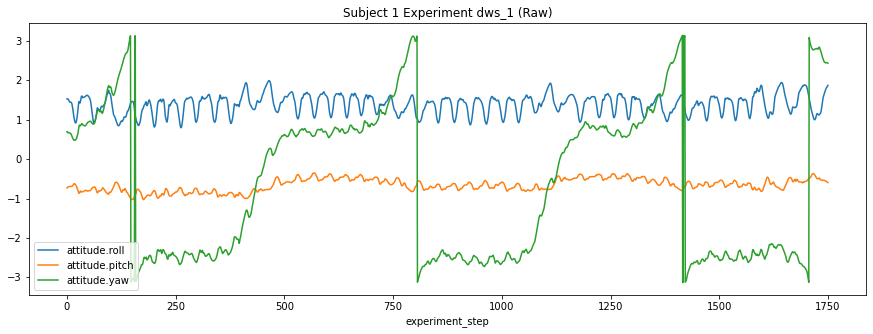

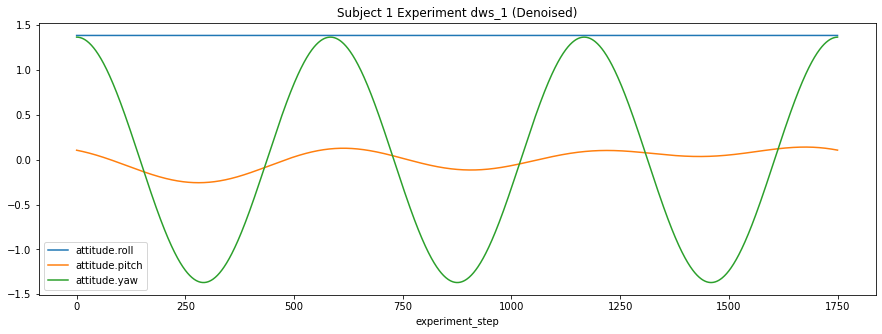

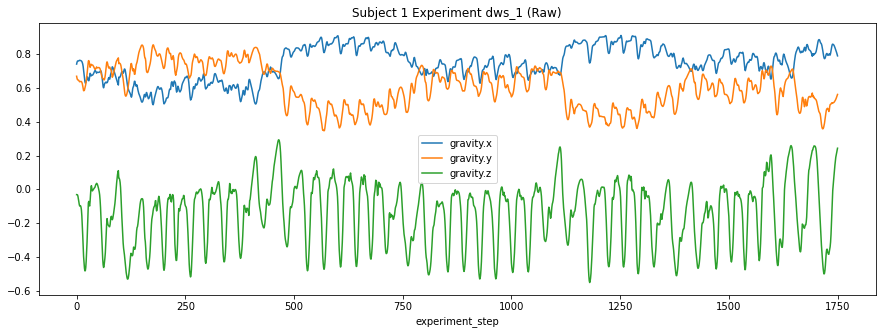

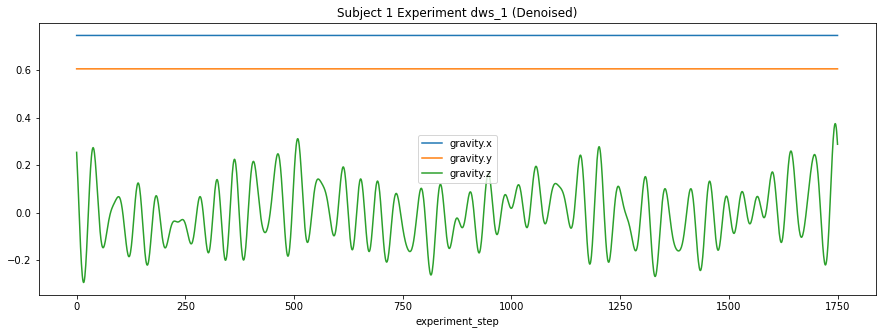

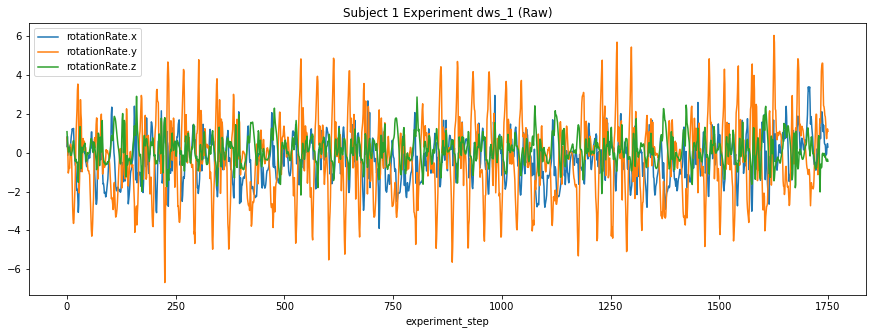

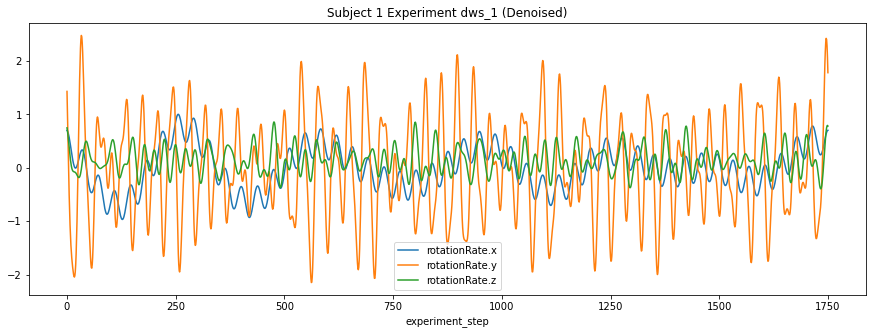

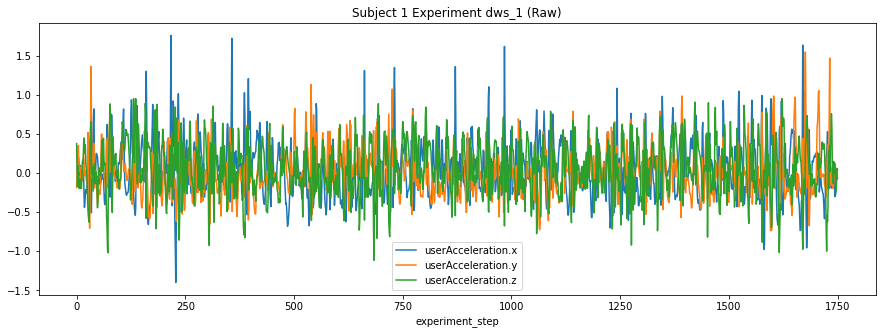

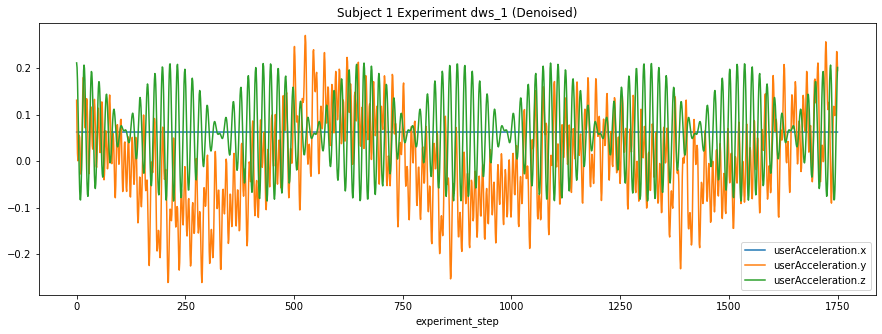

In [17]:
plot_experiment_in_time_domain(raw_df,denoised_df,1,1)

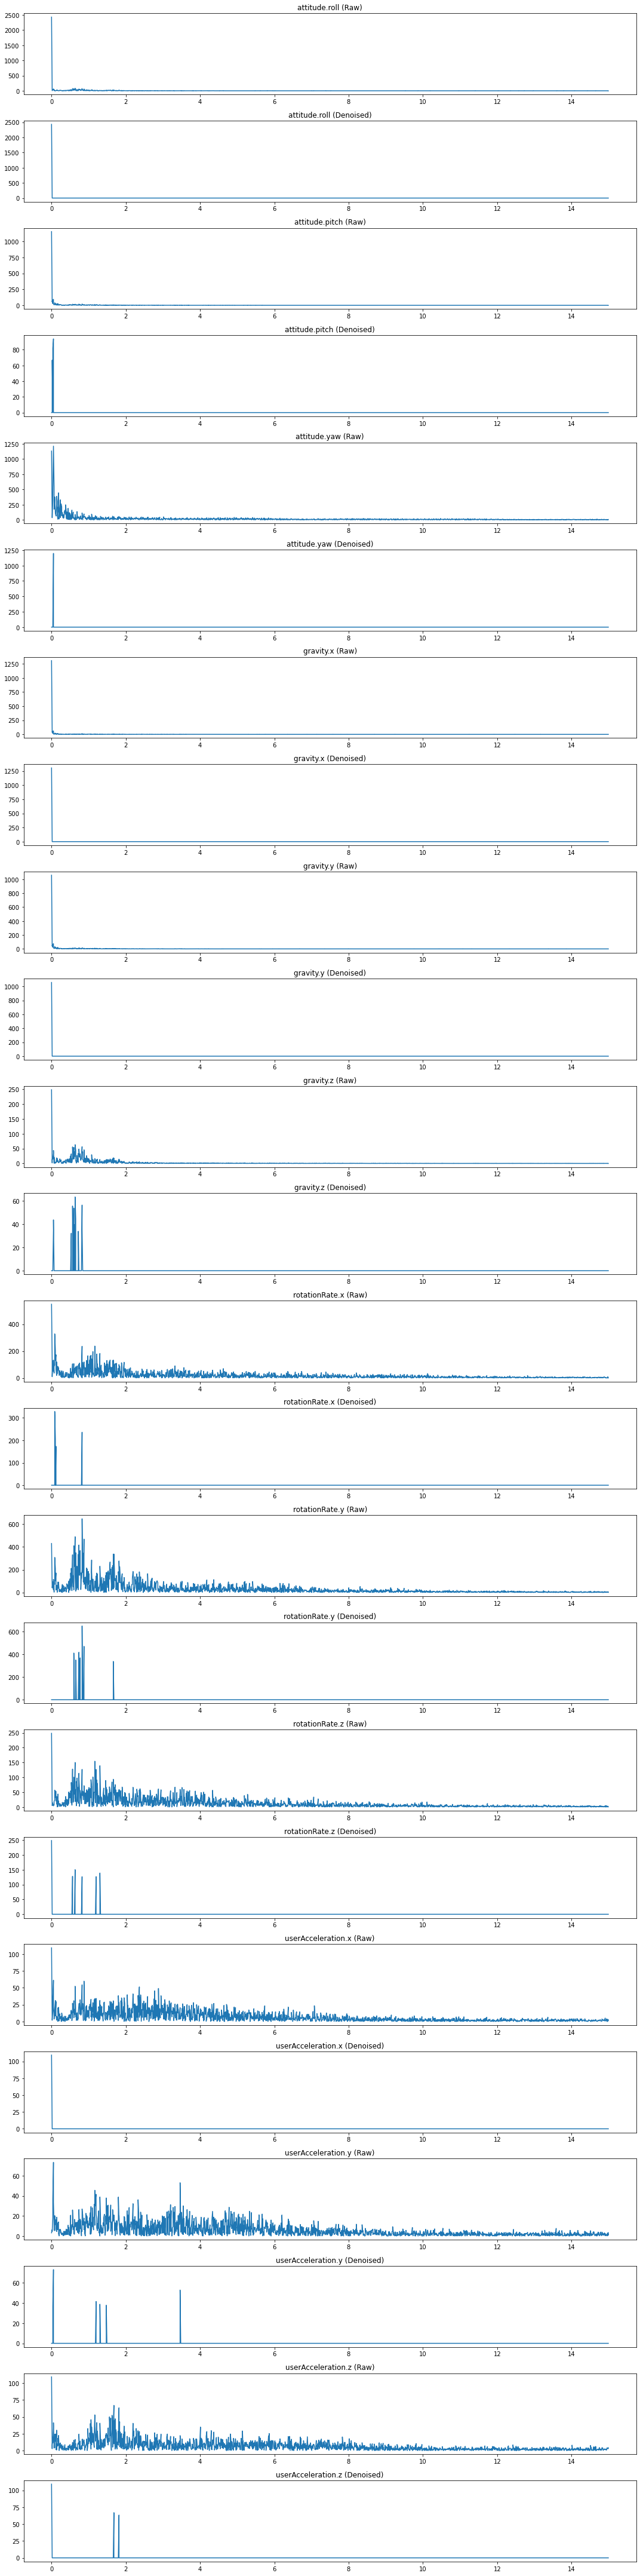

In [18]:
plot_experiment_in_frequency_domain(raw_df, denoised_df, 1, 1)

# Extract feature

In [ ]:
def extract_freq_feature(series):
    freq_spectrum = rfft(series.to_numpy())
    
    max_amp = np.amax(freq_spectrum)
    main_freq = np.argmax(freq_spectrum)
    
    return [max_amp, main_freq]

In [ ]:
def get_processed_df(df, window_size, step_size, time_features, extract_frequency=True):
    """
    Use sliding windows methods to extract features per experiment and subject
    """
    grouped_df = df.groupby(['subject', 'experiment_id'])
    processed_dfs = []
    for (subject, experiment), data in grouped_df: # iterate over data per subject per experiment

        activity = data.activity.values[0] # all activites in this experiment are the same
        
        windows_list = []
        for start in range(0, len(data) - window_size, step_size):
            end = start + window_size
            values = data[MOTION_SENSOR_COLUMNS].iloc[start : end]
            
            # extract time domain features
            time_feature_table = values.agg(time_features)
            
            window = time_feature_table.unstack().to_frame().T
            window.columns = window.columns.map('_'.join)

            # extract frequency domain features
            if extract_frequency:
                for reading in MOTION_SENSOR_COLUMNS:
                    freq_features = extract_freq_feature(values[reading])
                    window[reading + '_max_amp'] = freq_features[0]
                    window[reading + '_main_freq'] = freq_features[1]
            
            # add index range
            window['index_range'] = "{}-{}".format(start, end)

            windows_list.append(window)

        if len(windows_list) == 0:
            continue
        
        processed_df = pd.concat(windows_list)
        
        processed_df['activity'] = activity # this will be the label
        processed_df['subject'] = subject
        processed_df['experiment'] = experiment

        processed_dfs.append(processed_df)
    
    processed_data = pd.concat(processed_dfs)
    return processed_data

In [ ]:
time_features = ['min', 'max', 'mean', 'std']
# processed_data = get_processed_df(denoised_df, 100, 25, time_features)
# processed_data1 = get_processed_df(denoised_df, 100, 50, time_features)
# processed_data2 = get_processed_df(denoised_df, 200, 50, time_features)
# processed_data3 = get_processed_df(denoised_df, 200, 100, time_features)
# processed_data4 = get_processed_df(denoised_df, 300, 75, time_features)
# processed_data5 = get_processed_df(denoised_df, 300, 150, time_features)

# processed_data = get_processed_df(denoised_df, 100, 25, time_features, extract_frequency=False)

In [ ]:
# processed_data.columns

In [ ]:
# processed_data.isnull().sum()

In [ ]:
# exp_data = processed_data.loc[(processed_data['experiment'] == 1) & (processed_data['subject'] == 1)]
# exp_data.head(100)

In [ ]:
# processed_data.shape

In [ ]:
# processed_data.to_csv('processed_data_100_25.csv', index=False)
# processed_data1.to_csv('processed_data_100_50.csv', index=False)
# processed_data2.to_csv('processed_data_200_50.csv', index=False)
# processed_data3.to_csv('processed_data_200_100.csv', index=False)
# processed_data4.to_csv('processed_data_300_75.csv', index=False)
# processed_data5.to_csv('processed_data_300_150.csv', index=False)


# processed_data.to_csv('processed_data_time_feat_only.csv', index=False)

In [23]:
pd.read_csv('processed_data_100_25.csv').head()

attitude.roll_min  attitude.roll_max  attitude.roll_mean  \
0           1.387143           1.387143            1.387143   
1           1.387143           1.387143            1.387143   
2           1.387143           1.387143            1.387143   
3           1.387143           1.387143            1.387143   
4           1.387143           1.387143            1.387143   

   attitude.roll_std  attitude.pitch_min  attitude.pitch_max  \
0       6.694897e-16           -0.035591            0.107185   
1       6.694897e-16           -0.080355            0.079823   
2       6.694897e-16           -0.124328            0.045613   
3       6.694897e-16           -0.165102            0.005940   
4       6.694897e-16           -0.200373           -0.037366   

   attitude.pitch_mean  attitude.pitch_std  attitude.yaw_min  \
0             0.042728            0.042434          0.662194   
1             0.004353            0.047574          0.319904   
2            -0.037474            0.050473         -0.045417   
3            -0.080687            0.050827         -0.407469   
4            -0.123027            0.048500         -0.740185   

   attitude.yaw_max  attitude.yaw_mean  attitude.yaw_std  gravity.x_min  \
0          1.368568           1.122724          0.216793       0.745272   
1          1.319304           0.906251          0.301149       0.745272   
2          1.175061           0.624533          0.365499       0.745272   
3          0.946222           0.297855          0.404431       0.745272   
4          0.649263          -0.050267          0.414895       0.745272   

   gravity.x_max  gravity.x_mean  gravity.x_std  gravity.y_min  gravity.y_max  \
0       0.745272        0.745272   1.115816e-16       0.604755       0.604755   
1       0.745272        0.745272   1.115816e-16       0.604755       0.604755   
2       0.745272        0.745272   1.115816e-16       0.604755       0.604755   
3       0.745272        0.745272   1.115816e-16       0.604755       0.604755   
4       0.745272        0.745272   1.115816e-16       0.604755       0.604755   

   gravity.y_mean  gravity.y_std  gravity.z_min  gravity.z_max  \
0        0.604755   1.115816e-16      -0.294084       0.273514   
1        0.604755   1.115816e-16      -0.185140       0.273514   
2        0.604755   1.115816e-16      -0.185140       0.124332   
3        0.604755   1.115816e-16      -0.220565       0.124332   
4        0.604755   1.115816e-16      -0.220565       0.124332   

   gravity.z_mean  gravity.z_std  rotationRate.x_min  rotationRate.x_max  \
0       -0.004319       0.151401           -0.866447            0.700358   
1        0.004652       0.125386           -0.919914            0.336770   
2       -0.027609       0.091256           -0.963881           -0.135985   
3       -0.039512       0.104432           -0.963881           -0.183490   
4       -0.048454       0.102837           -0.963881            0.141232   

   rotationRate.x_mean  rotationRate.x_std  rotationRate.y_min  \
0            -0.126881            0.418110           -2.040781   
1            -0.346154            0.360318           -1.874325   
2            -0.545162            0.239536           -1.874325   
3            -0.597292            0.203389           -1.546278   
4            -0.438942            0.310582           -1.546278   

   rotationRate.y_max  rotationRate.y_mean  rotationRate.y_std  \
0            2.476557            -0.092954            1.214791   
1            2.476557             0.099961            1.009152   
2            1.280440            -0.057141            0.826545   
3            1.360554             0.044556            0.741885   
4            1.360554            -0.055131            0.821184   

   rotationRate.z_min  rotationRate.z_max  rotationRate.z_mean  \
0           -0.180721            0.748667             0.126633   
1           -0.188964            0.527257             0.142589   
2           -0.188964            0.527643             0.131803   
3   